# Single Cell RNA Seq Data Analysis using Seurat_part_2

In [1]:
# load data
lung.seurat.obj <- readRDS("lung_seurat_NSCLC.rds")

In [2]:
library(Seurat)

# Ensure plots render inline
options(jupyter.plot_mimetypes = c("image/png"))

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




### Clustering the Data

In [3]:
# Clustering the Data
lung.seurat.obj <- FindNeighbors(lung.seurat.obj, dims = 1:15)
lung.seurat.obj <- FindClusters(lung.seurat.obj, resolution = c(0.1, 0.3, 0.5, 0.7, 1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48919

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9653
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48919

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9124
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48919

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8709
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1256
Number of edges: 48919

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8332
Number of communities: 10
Elapsed time: 0 seconds
Modularity Optimizer ve

In [4]:
#set the identity of cells based on a specific resolution. For instance, at resolution 0.3
Idents(lung.seurat.obj) <- "RNA_snn_res.0.3"

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:01:59 UMAP embedding parameters a = 0.9922 b = 1.112

14:01:59 Read 1256 rows and found 15 numeric columns

14:01:59 Using Annoy for neighbor search, n_neighbors = 30

14:01:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:01:59 Writing NN index file to temp file /tmp/RtmpmNx79S/file3eb74e3cd3e3

14:01:59 Searching Annoy index using 1 thread, search_k = 3000

14:02:00 Annoy recall = 100%

14:02:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

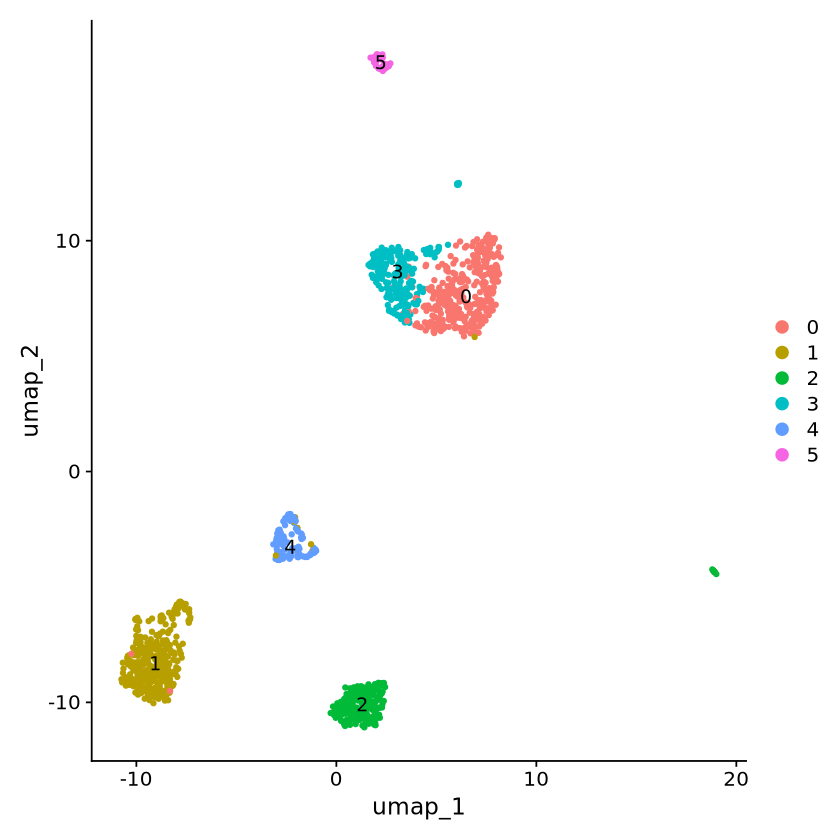

In [5]:
lung.seurat.obj <- RunUMAP(lung.seurat.obj, dims = 1:15)
# Plotting UMAP
DimPlot(lung.seurat.obj, reduction = "umap", label = TRUE)

## Cell Type Annotation

In [6]:
# Load necessary library
library(dplyr)
library(ggplot2)
library(SingleR)
library(celldex) # 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeigh

In [7]:
# Download a reference dataset from celldex.
# HumanPrimaryCellAtlasData is a common and robust choice.
ref.data <- HumanPrimaryCellAtlasData()

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


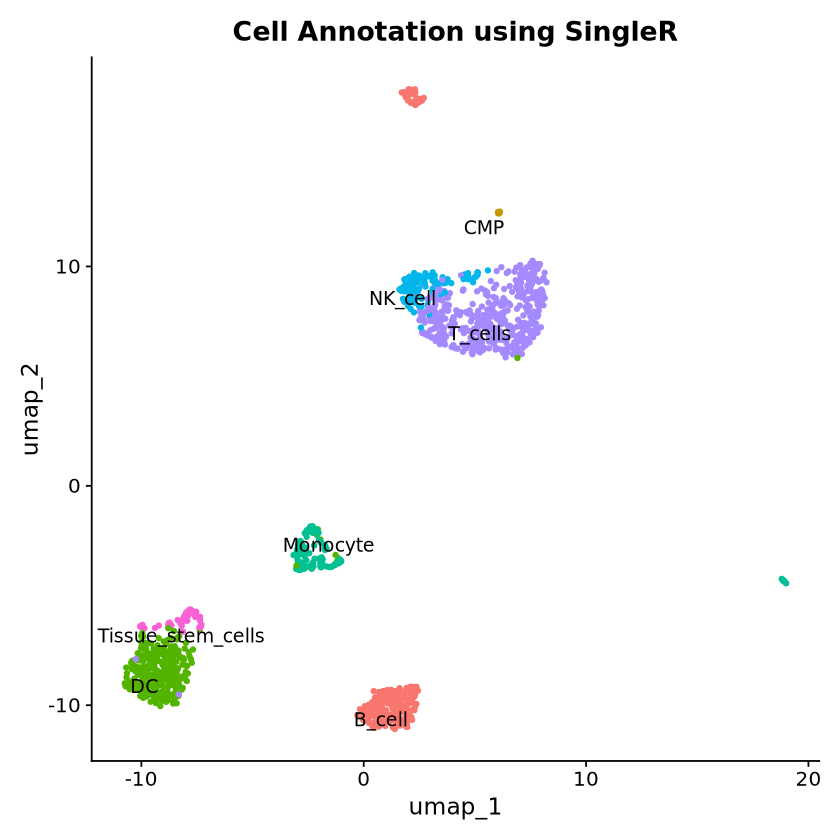

In [8]:
library(SingleR)

# Use RNA assay counts (or log-normalized counts)
expr.mat <- as.matrix(GetAssayData(lung.seurat.obj, slot = "data"))  # log-normalized
# or for raw counts
# expr.mat <- as.matrix(GetAssayData(lung.seurat.obj, slot = "counts"))

# 4. Run SingleR at cluster level (using Leiden clusters)
pred.cluster <- SingleR(
  test = expr.mat,
  ref = ref.data,
  labels = ref.data$label.main,
  clusters = lung.seurat.obj$seurat_clusters
)

# 5. Map cluster annotations back to cells
cluster.annotations <- pred.cluster$labels
names(cluster.annotations) <- rownames(pred.cluster)
cell.annotations <- cluster.annotations[as.character(lung.seurat.obj$seurat_clusters)]
names(cell.annotations) <- colnames(lung.seurat.obj)

# 6. Add to Seurat metadata
lung.seurat.obj <- AddMetaData(
  object = lung.seurat.obj,
  metadata = cell.annotations,
  col.name = "SingleR_cluster"
)

# 7. Visualize annotationsbb
DimPlot(lung.seurat.obj, group.by = "SingleR_cluster", label = TRUE, repel = TRUE) + NoLegend() + ggtitle("Cell Annotation using SingleR")

### Differential Expression Analysis for Each Cluster

In [9]:
# Differential expression analysis for each cluster
markers <- FindAllMarkers(lung.seurat.obj, only.pos = TRUE, logfc.threshold = 0.25)
#head(markers)


Calculating cluster 0

Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



In [10]:
# get top marker per cluster
top.markers <- markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
head(top.markers)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.289687e-15,6.316240,0.073,0.001,7.124820e-11,0,FBLN7
1.111361e-11,8.019483,0.051,0.000,3.458223e-07,0,IL21
1.712982e-06,6.924650,0.025,0.000,5.330285e-02,0,CDO1
6.509455e-06,6.016570,0.022,0.000,2.025547e-01,0,TRAV13-2
3.705442e-04,6.156597,0.014,0.000,1.000000e+00,0,LINC01229
2.224585e-05,8.474392,0.020,0.000,6.922241e-01,1,STON2


In [11]:
# Compare each SingleR-annotated cell type against all others
markers_celltype <- FindAllMarkers(
  object = lung.seurat.obj,
  group.by = "SingleR_cluster",
  only.pos = TRUE,
  logfc.threshold = 0.2,
  min.pct = 0.1
)

# View top markers per cell type
top_markers <- markers_celltype %>%
  group_by(cluster) %>%
  slice_max(order_by = avg_log2FC, n = 5) %>%
  ungroup() %>%
  select(cluster, gene, avg_log2FC, pct.1, pct.2, p_val_adj)

top_markers

Calculating cluster B_cell

Calculating cluster DC

Calculating cluster T_cells

Calculating cluster Tissue_stem_cells

Calculating cluster NK_cell

Calculating cluster Monocyte

Calculating cluster CMP



cluster,gene,avg_log2FC,pct.1,pct.2,p_val_adj
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B_cell,CD19,7.691227,0.148,0.001,6.919483e-30
B_cell,FCER2,7.498484,0.106,0.001,5.587811e-20
B_cell,IGHA2,7.418103,0.136,0.003,2.211134e-24
B_cell,IGHD,6.790651,0.114,0.003,1.318284e-19
B_cell,IGLC1,5.865894,0.258,0.092,1.237577e-07
DC,MIR205HG,3.643418,0.153,0.092,1.000000e+00
DC,CLDN4,3.577078,0.143,0.101,1.000000e+00
DC,WFDC2,3.501194,0.156,0.111,1.000000e+00
DC,COL1A2,3.149028,0.136,0.082,1.000000e+00




clusterProfiler v4.17.0 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:clusterProfiler’:

    select


The following object is masked from ‘package:dplyr’:

    select




'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(hvg, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“9.45% of input gene IDs are fail to map...”


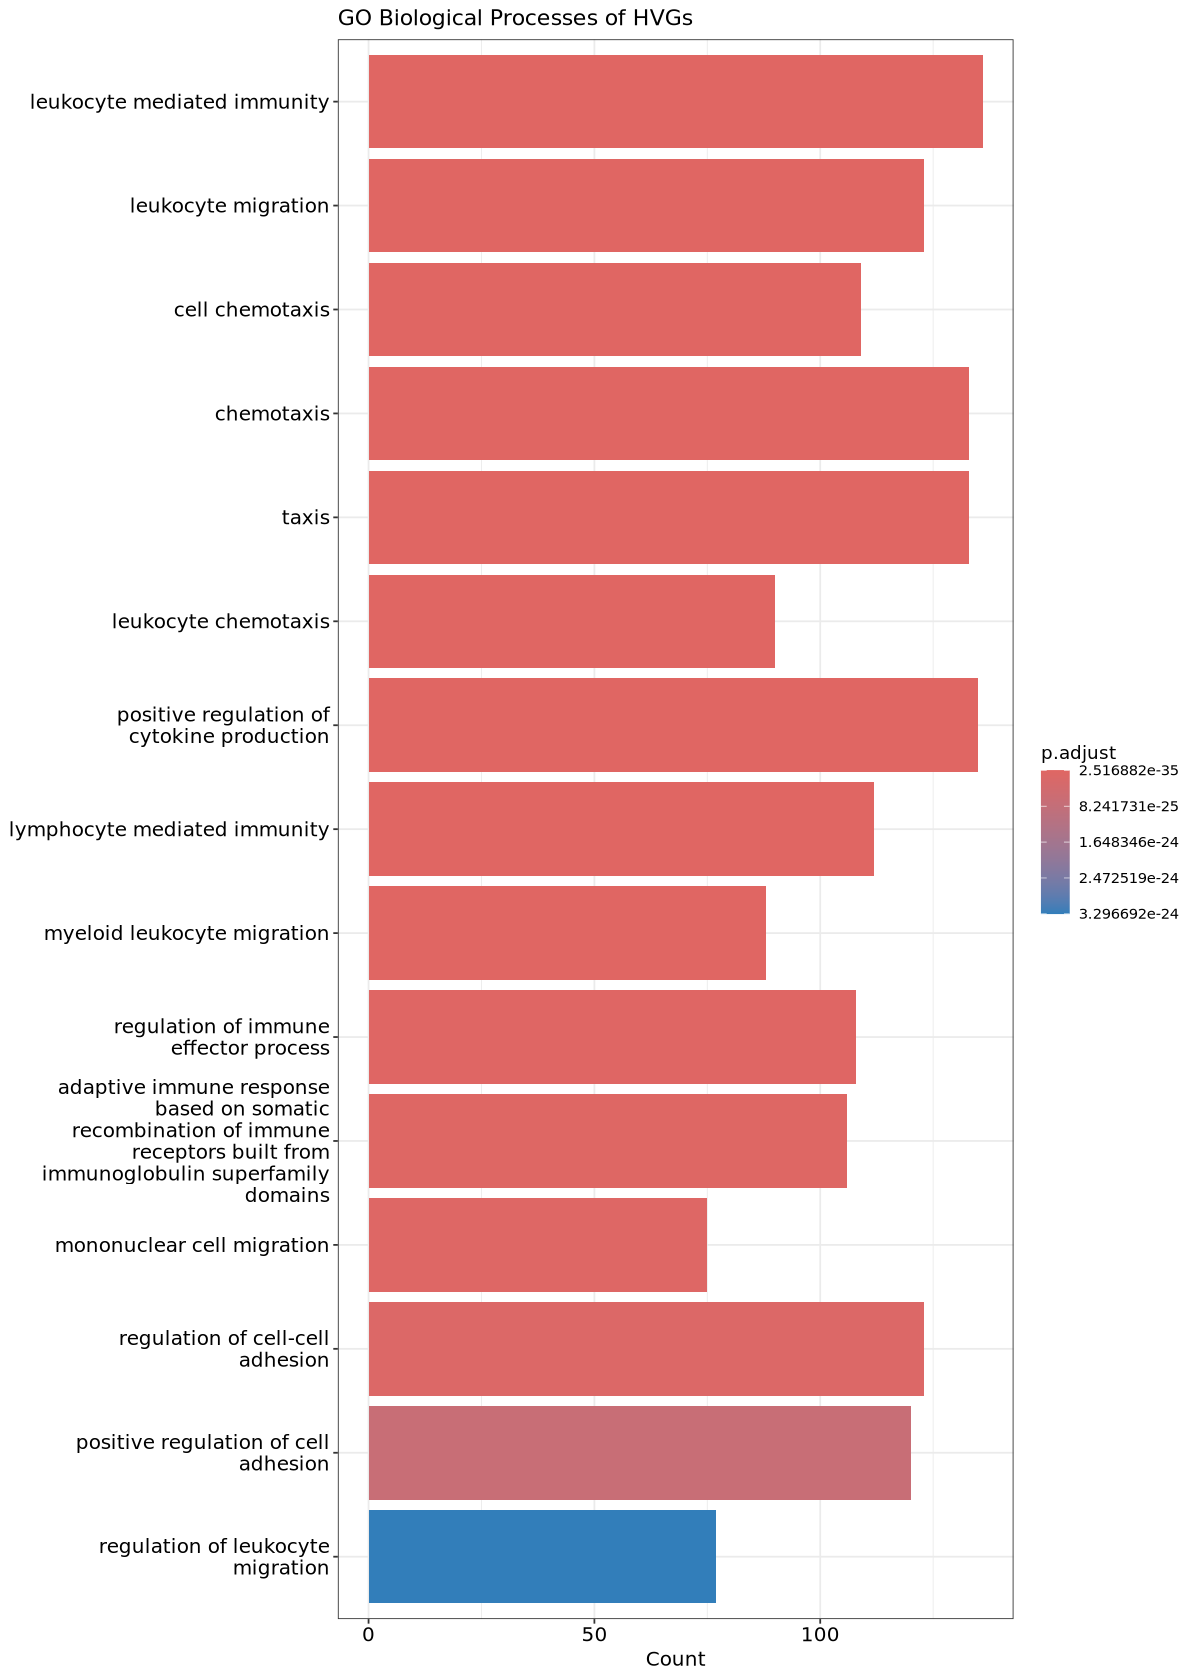

In [12]:
# Load necessary libraries
library(Seurat)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)

# Step 1: Extract highly variable genes
hvg <- VariableFeatures(lung.seurat.obj)

# Filter HVGs that look like standard gene symbols (no dots or long lncRNAs)
hvg_filtered <- hvg[!grepl("\\.", hvg)]

# Step 2: Map HVG gene symbols to Entrez IDs
gene_entrez <- bitr(hvg, 
                    fromType = "SYMBOL", 
                    toType = "ENTREZID", 
                    OrgDb = org.Hs.eg.db)

# Step 3 (Optional): Filter HVGs to only those that mapped
mapped_genes <- gene_entrez$SYMBOL
hvg_mapped <- hvg[hvg %in% mapped_genes]

# Step 4: GO Biological Process enrichment
ego_bp <- enrichGO(
  gene          = gene_entrez$ENTREZID,
  OrgDb         = org.Hs.eg.db,
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.2,
  readable      = TRUE
)

#Make plot larger
options(repr.plot.width = 10, repr.plot.height = 14)

# Step 5: Plot top 15 GO BP terms
barplot(ego_bp, showCategory = 15) + 
  ggtitle("GO Biological Processes of HVGs")



In [13]:
file.info("scRNAseq_Analysis_Seurat_Part_2.ipynb")$size / (1024^2)  # Size in MB

[1] 0.1618328